In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

In [2]:
c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

def read_tempdata2(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
#     arr = arr - c_error
    arr = np.amax(arr, axis = 0) - c_maxnoise
    return arr

def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
amb_dis = np.array([[ 4.6 ,  4.63,  4.7 ,  4.55],
       [ 6.05,  6.1 ,  5.64,  5.23],
       [ 8.33,  8.34,  6.97,  6.2 ],
       [10.02,  9.26,  8.69,  8.49]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp + ans).round(2)

In [4]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)

    weight = np.ones(diff.shape[0])
    for i in range(diff.shape[0]):
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.

        gmm = mixture.GaussianMixture(n_components = 2)
        gmm = gmm.fit(X=bicubic.reshape(-1,1))
        gmm_x = np.linspace(np.amin(bicubic),np.amax(bicubic),100)
        gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
        gmm_y2 = gmm.predict_proba(gmm_x.reshape(-1,1))
        if np.argmax(gmm_y2[:,0]*gmm_y) > np.argmax(gmm_y2[:,1]*gmm_y):
            gmm_y2[:,[0,1]] = gmm_y2[:,[1,0]]
        weight[i] = gmm_x[np.argmax(gmm_y2[:,0]*gmm_y)]
        
    return weight

In [5]:
def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = np.floor(np.amin(bicubic)), vmax = np.ceil(np.amax(bicubic)))
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)

In [6]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            if nx == 1:
                y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
                y1 = y2-1
                ly = i*(oy-1)/(ny-1) - y1
                interpol[i,j] = garr2[y1,j-1]*(1-ly)+garr2[y2,j-1]*ly
                continue
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'
        garr = read_gtempdata(100,datapath,ln**2)
        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    tt = 9
    x_train = np.zeros((4,dis,ln**2,100,8,8))
#     arrbg = np.zeros((4,1,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        bgpath = 'train/' + temp_path[i] + '/output-empty/1.txt'
#         arrbg[i] = read_tempdata2(100,bgpath)
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
#     arrbg = thermal_interpolate(arrbg,4,1,16,1)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis).reshape(16,dis,-1).transpose(2,1,0)
    print("interpolation complete")
    
    
    temp_arr = np.array([30.144493323714006, 28.117090641951425, 25.753330476546328, 22.539413382301674])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,tt,16,dis,ln**2))

    y_train[1] = (np.ones((tt,dis,ln**2,16))*temp_inter).transpose(0,3,1,2)
    y_train[2] = (np.ones((tt,16,ln**2,dis))*np.linspace(1,4,dis)).transpose(0,1,3,2)
    pos_x = np.array([np.arange(1/6,2,1/3),]*6)-1
    pos_y = pos_x.T
    y_train[3] = (np.ones((tt,16,dis,ln**2))*pos_x.reshape(-1))
    y_train[4] = (np.ones((tt,16,dis,ln**2))*pos_y.reshape(-1))
    y_train = y_train.reshape(5,tt,16*dis,-1).transpose(0,2,3,1) #5,16*dis,36,tt
    y_temp = np.linspace(36,40,tt)
    for i in range(y_train.shape[1]):
        _a = y_train[1,i,0,0]
        _b = y_train[2,i,0,0]
        y_train[0,i] =np.ones((36,tt))*(y_temp-get_bodytemp(0,_a,_b))
    temp_inter += 0.5
    o_skintemp = y_train[0,:,0,1].reshape(16,-1).transpose(1,0)

    y_train[0] = (y_train[0]-29)/7
    y_train[1] = (y_train[1]/25) -1
    y_train[2] = (y_train[2]-2.5)*0.5
    
    y_train = y_train.transpose(3,1,2,0).reshape(-1,5)

    print("y_train complete")
    _x = np.clip((x_train-temp_inter)/(o_skintemp-temp_inter),0,1).transpose(2,1,0).reshape(-1)
    x_train = (1-_x)*x_train.transpose(2,1,0).reshape(-1)
    x_train = ((np.ones((58982400,tt))*y_temp).transpose(1,0)*_x + x_train).reshape(tt,16*16*36*100,-1).transpose(0,1,2).reshape(-1,8,8,1)
    
    y_train = (np.ones((100,y_train.shape[0],5))*y_train).transpose(1,0,2).reshape(-1,5)
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train[indices[:-ind]], y_train[indices[:-ind]], x_train[indices[-ind:-ind_half]], y_train[indices[-ind:-ind_half]], x_train[indices[-ind_half:]], y_train[indices[-ind_half:]]

In [7]:
x_train, y_train, x_test, y_test, x_val, y_val = load_temperature()

interpolation complete
y_train complete


In [8]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(6635520, 8, 8, 1)
(829440, 8, 8, 1)
(829440, 8, 8, 1)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          640       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 64)         

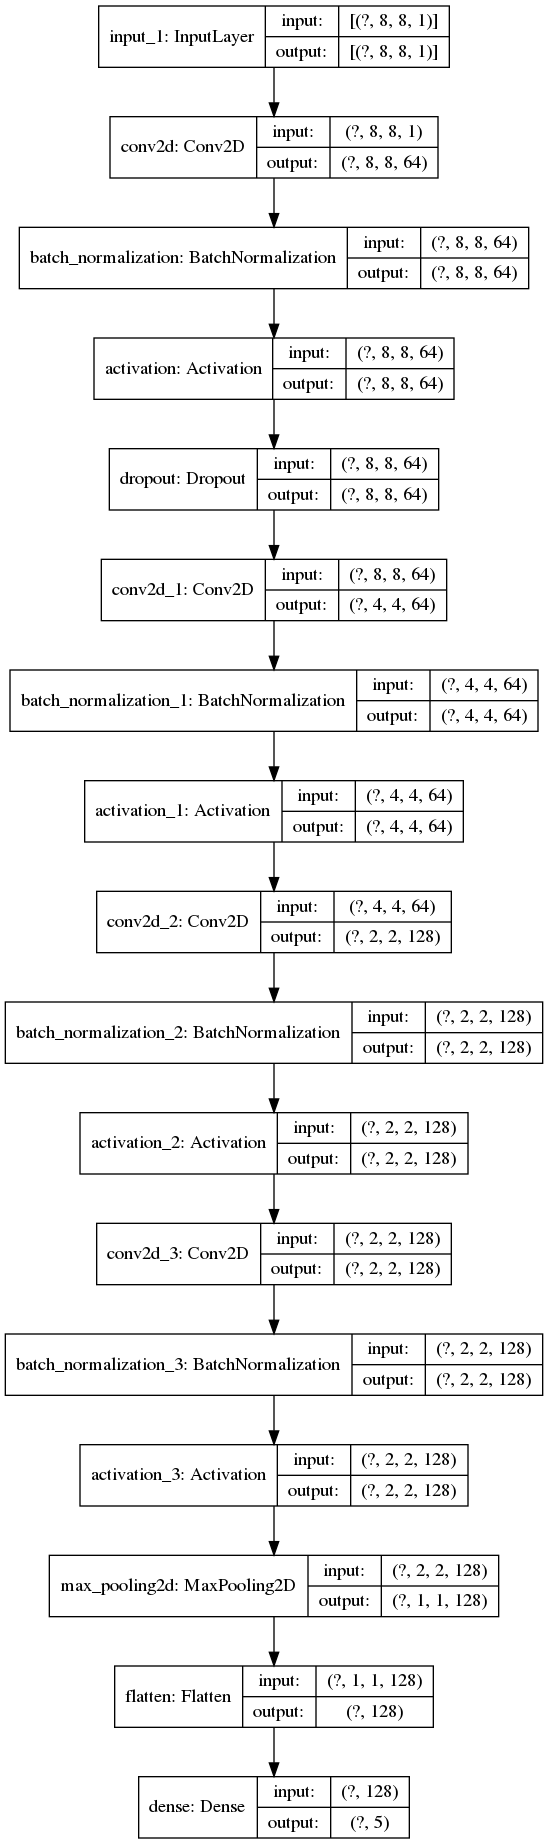

In [9]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 64
dropout = 0.5
init = RandomNormal(stddev=0.02)

inputs = Input(shape=input_shape)


y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          padding = 'same')(inputs)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Dropout(dropout)(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
# y = MaxPooling2D()(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = MaxPooling2D()(y)

y = Flatten()(y)
outputs = Dense(5, activation='tanh')(y)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [10]:
opt = Adam(lr=0.0003, beta_1=0.9)
model.compile(loss='mae',
              optimizer= opt,
              metrics=['accuracy'])
batch_size = 256
history = model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=200,
          batch_size=batch_size)

score = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nVal accuracy: %.1f%%" % (100.0 * score[1]))

score = model.evaluate(x_val, y_val, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

Epoch 1/200
25920/25920 [==============================] - 79s 3ms/step - loss: 0.1019 - accuracy: 0.7771 - val_loss: 0.1052 - val_accuracy: 0.7745
Epoch 2/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0598 - accuracy: 0.8539 - val_loss: 0.1494 - val_accuracy: 0.7039
Epoch 3/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0491 - accuracy: 0.8725 - val_loss: 0.1011 - val_accuracy: 0.7540
Epoch 4/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0434 - accuracy: 0.8834 - val_loss: 0.1123 - val_accuracy: 0.7205
Epoch 5/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0402 - accuracy: 0.8890 - val_loss: 0.0705 - val_accuracy: 0.8140
Epoch 6/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0381 - accuracy: 0.8928 - val_loss: 0.0412 - val_accuracy: 0.8758
Epoch 7/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0365 - accuracy: 0.8957 - val_

25920/25920 [==============================] - 78s 3ms/step - loss: 0.0219 - accuracy: 0.9166 - val_loss: 0.0279 - val_accuracy: 0.9083
Epoch 57/200
25920/25920 [==============================] - 78s 3ms/step - loss: 0.0218 - accuracy: 0.9169 - val_loss: 0.0458 - val_accuracy: 0.8183
Epoch 58/200
25920/25920 [==============================] - 79s 3ms/step - loss: 0.0218 - accuracy: 0.9170 - val_loss: 0.0226 - val_accuracy: 0.9223
Epoch 59/200
25920/25920 [==============================] - 78s 3ms/step - loss: 0.0217 - accuracy: 0.9171 - val_loss: 0.0202 - val_accuracy: 0.9277
Epoch 60/200
25920/25920 [==============================] - 78s 3ms/step - loss: 0.0216 - accuracy: 0.9174 - val_loss: 0.0292 - val_accuracy: 0.8963
Epoch 61/200
25920/25920 [==============================] - 78s 3ms/step - loss: 0.0215 - accuracy: 0.9174 - val_loss: 0.0293 - val_accuracy: 0.8563
Epoch 62/200
25920/25920 [==============================] - 78s 3ms/step - loss: 0.0215 - accuracy: 0.9174 - val_loss: 

Epoch 111/200
25920/25920 [==============================] - 81s 3ms/step - loss: 0.0194 - accuracy: 0.9213 - val_loss: 0.0337 - val_accuracy: 0.8430
Epoch 112/200
25920/25920 [==============================] - 79s 3ms/step - loss: 0.0194 - accuracy: 0.9215 - val_loss: 0.0304 - val_accuracy: 0.8600
Epoch 113/200
25920/25920 [==============================] - 81s 3ms/step - loss: 0.0194 - accuracy: 0.9214 - val_loss: 0.0260 - val_accuracy: 0.8697
Epoch 114/200
25920/25920 [==============================] - 80s 3ms/step - loss: 0.0194 - accuracy: 0.9215 - val_loss: 0.0228 - val_accuracy: 0.9233
Epoch 115/200
25920/25920 [==============================] - 86s 3ms/step - loss: 0.0193 - accuracy: 0.9215 - val_loss: 0.0173 - val_accuracy: 0.8992
Epoch 116/200
25920/25920 [==============================] - 85s 3ms/step - loss: 0.0193 - accuracy: 0.9215 - val_loss: 0.0318 - val_accuracy: 0.8553
Epoch 117/200
25920/25920 [==============================] - 86s 3ms/step - loss: 0.0193 - accuracy:

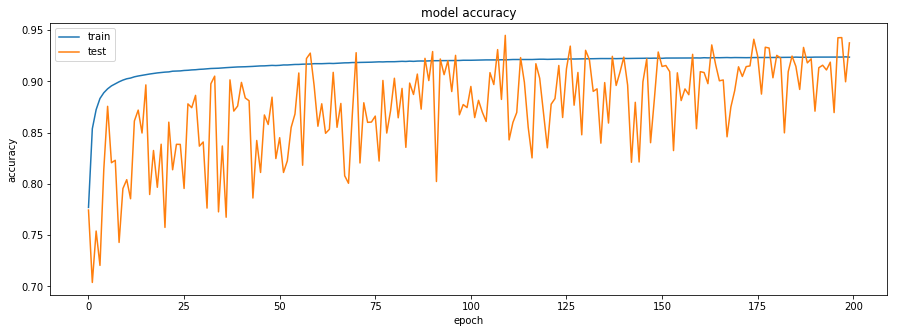

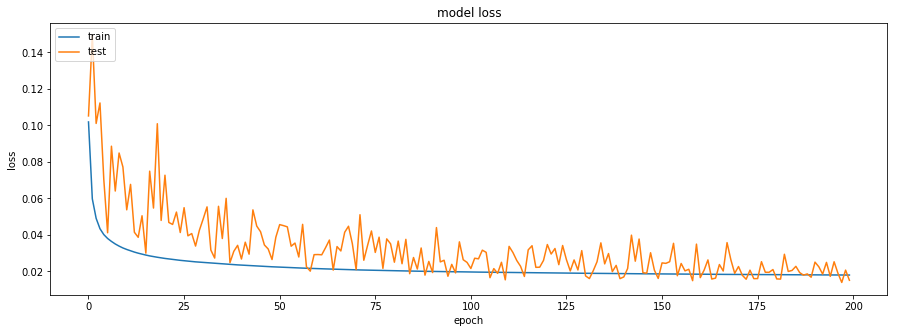

In [11]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [12]:
res = model.predict(x_val)*np.array([7,25,2,3,3])+np.array([29,25,2.5,3.5,3.5])
yy =y_val*np.array([7,25,2,3,3])+np.array([29,25,2.5,3.5,3.5])

In [13]:
a = abs(yy - res)
print(np.median(a,axis = 0).round(2))

[0.25 0.06 0.02 0.01 0.  ]


In [14]:
get_bodytemp(31.94, 26.7 ,  4.)

37.71

In [15]:
yy[:100].round(2)

array([[30.86, 28.52,  2.4 ,  4.  ,  5.  ],
       [28.55, 23.18,  3.6 ,  2.  ,  2.  ],
       [31.28, 26.23,  2.2 ,  2.  ,  5.  ],
       [30.48, 27.64,  3.6 ,  5.  ,  3.  ],
       [35.25, 29.74,  3.8 ,  4.  ,  5.  ],
       [29.82, 23.82,  2.2 ,  5.  ,  5.  ],
       [29.48, 25.11,  1.8 ,  6.  ,  2.  ],
       [26.87, 23.82,  1.8 ,  4.  ,  5.  ],
       [27.81, 22.54,  3.  ,  4.  ,  3.  ],
       [30.93, 26.23,  1.8 ,  2.  ,  5.  ],
       [28.46, 25.75,  1.2 ,  6.  ,  1.  ],
       [31.06, 24.47,  4.  ,  3.  ,  1.  ],
       [34.23, 28.93,  2.8 ,  2.  ,  5.  ],
       [33.87, 30.14,  2.  ,  1.  ,  2.  ],
       [27.27, 23.82,  1.  ,  2.  ,  2.  ],
       [28.3 , 23.18,  3.2 ,  2.  ,  3.  ],
       [30.94, 25.75,  2.6 ,  2.  ,  2.  ],
       [34.91, 29.33,  2.  ,  6.  ,  6.  ],
       [33.18, 25.11,  3.4 ,  3.  ,  3.  ],
       [27.56, 24.47,  2.2 ,  1.  ,  2.  ],
       [29.83, 25.11,  1.4 ,  2.  ,  6.  ],
       [33.86, 28.12,  3.  ,  3.  ,  3.  ],
       [33.92, 29.33,  2.4 ,  2.

In [16]:
for i in range(100):
    print([get_bodytemp(res[i,0],res[i,1],res[i,2]),get_bodytemp(yy[i,0],yy[i,1],yy[i,2])])

[36.19, 36.5]
[36.79, 36.5]
[38.51, 39.0]
[36.22, 36.0]
[39.42, 40.0]
[38.97, 39.0]
[38.59, 38.5]
[36.55, 36.5]
[36.26, 36.5]
[38.61, 39.0]
[37.02, 37.0]
[37.96, 38.0]
[39.22, 39.5]
[37.75, 38.5]
[36.57, 37.0]
[36.53, 36.5]
[37.28, 38.5]
[40.07, 40.0]
[39.44, 40.0]
[36.58, 36.5]
[38.37, 39.0]
[38.87, 39.5]
[38.11, 39.0]
[38.53, 39.0]
[38.39, 38.0]
[37.71, 38.5]
[36.57, 36.5]
[37.68, 37.0]
[37.29, 38.0]
[38.3, 38.5]
[39.08, 38.5]
[38.16, 38.5]
[37.1, 37.0]
[38.52, 39.0]
[37.55, 37.5]
[38.69, 39.0]
[39.74, 40.0]
[36.77, 37.0]
[36.98, 37.5]
[38.72, 38.5]
[37.36, 38.0]
[37.26, 37.5]
[37.82, 37.5]
[36.05, 36.0]
[36.68, 37.0]
[37.2, 37.5]
[36.56, 36.5]
[36.62, 37.0]
[38.8, 39.5]
[36.92, 38.0]
[37.24, 37.5]
[39.16, 39.5]
[36.3, 36.5]
[36.65, 36.5]
[38.59, 38.0]
[37.42, 37.5]
[36.36, 36.0]
[36.24, 36.0]
[36.66, 37.0]
[39.54, 40.0]
[39.89, 40.0]
[38.61, 39.0]
[38.05, 38.0]
[37.17, 38.0]
[36.63, 36.5]
[36.86, 37.5]
[37.02, 37.5]
[37.21, 37.5]
[36.87, 37.0]
[36.64, 36.5]
[37.07, 38.0]
[39.36, 39.

In [17]:
l = []
cnt = 0
for i in range(res.shape[0]):
    _a = abs(get_bodytemp(res[i,0],res[i,1],res[i,2])-get_bodytemp(yy[i,0],yy[i,1],yy[i,2]))
    if _a > 1:
       cnt+=1 
    l.append(_a)
print(np.median(np.array(l)))
print (cnt/res.shape[0])

0.2700000000000031
0.03471137152777778


In [18]:
l = []
cnt = 0
for i in range(res.shape[0]):
    _a = get_bodytemp(res[i,0],res[i,1],res[i,2])-get_bodytemp(yy[i,0],yy[i,1],yy[i,2])
    l.append(_a)

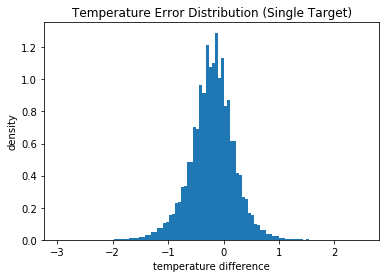

[-0.20322247540509256, -0.18999999999999773, 0.1584965488843238, 0.39811625046501653]


In [31]:
plt.hist(l, bins=100, density = True )
plt.title('Temperature Error Distribution (Single Target)')
plt.ylabel('density')
plt.xlabel('temperature difference')
plt.show()
print([np.mean(l),np.median(l),np.var(l),np.std(l)])

In [30]:
print([np.std(l)*2, np.mean(l)-np.std(l)*2, np.mean(l)+np.std(l)*2])

[0.7962325009300331, -0.9994549763351256, 0.5930100255249405]


In [29]:
model.save('singletarget_model.h5')